# Notes

Similar feature sets as iteration 1, except that we remove records that are considered as outliers at least in one column.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

sns.set_context('talk')

RND = 121

In [2]:
FILE_NAME = 'iteration-3-train-smote.csv'

input_train_path = os.path.join(
    '..',
    'dataset',
    'research-iteration',
    'feature-engineering',
    FILE_NAME
)

df_train = pd.read_csv(input_train_path)
df_train.head()

input_test_path = os.path.join(
    '..',
    'dataset',
    'research-iteration',
    'feature-engineering',
    FILE_NAME.replace('train','test')
)
df_test = pd.read_csv(input_test_path)
df_test.head()

,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,...,availability_mainly_not_orderable,availability_mainly_orderable,address_-99,address_1,address_2,time_of_day_afternoon,time_of_day_early_morning,time_of_day_evening,onlineStatus_-99,onlineStatus_0
0,20.0,5.0,369.698,10.0,19.99,29.99,224.90,2.0,19.99,19.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,8.0,5.0,1418.744,12.0,12.99,24.99,102.95,1.0,24.99,24.99,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15.0,6.0,2576.046,39.0,10.00,79.99,1747.63,6.0,19.99,79.99,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,9.0,5.0,1502.738,7.0,29.99,29.99,209.93,1.0,29.99,29.99,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,7.0,2098.095,35.0,9.99,159.95,1723.33,3.0,10.00,49.99,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [3]:
mask_is_outlier_column = df_train.columns.str.endswith('_is_outlier')
is_outlier_column_list = df_train.columns[mask_is_outlier_column]

df_train.drop(
    labels=is_outlier_column_list,
    axis=1,
    inplace=True
)
df_test.drop(
    labels=is_outlier_column_list,
    axis=1,
    inplace=True
)

# Prepare training and test set

In [4]:
row_count = df_train.shape[0]
row_count

238286

In [5]:
df_train.iloc[0]

startHour                                     18.000
startWeekday                                   5.000
duration                                    1816.133
cCount                                        36.000
cMinPrice                                      1.000
cMaxPrice                                     24.990
cSumPrice                                    419.810
bCount                                        10.000
bMinPrice                                      9.990
bMaxPrice                                     24.990
bSumPrice                                    146.910
bStep                                        -99.000
maxVal                                      3400.000
customerScore                                568.000
accountLifetime                              222.000
payments                                      21.000
age                                           51.000
lastOrder                                     11.000
availability_-99                              

In [6]:
categorical_feature_list = [
    'availability_-99', 'availability_completely_not_determinable',
    'availability_completely_not_orderable','availability_completely_orderable',
    'availability_mainly_not_determinable','availability_mainly_not_orderable', 
    'availability_mainly_orderable',
    'address_-99', 'address_1', 'address_2', 
    'time_of_day_afternoon','time_of_day_early_morning', 'time_of_day_evening', 
    'onlineStatus_-99','onlineStatus_0'
]

for col in categorical_feature_list:
    df_train[col] = df_train[col].astype(int)
    df_test[col] = df_test[col].astype(int)

In [7]:
target_class = 'order'

y_train = df_train[target_class].copy()
X_train = df_train.drop(labels=[target_class], axis=1)

y_test = df_test[target_class].copy()
X_test = df_test.drop(labels=[target_class], axis=1)

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(238286, 33) (238286,)
(74151, 33) (74151,)


In [9]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score

def evaluate_performance(y_true, y_pred, print_results = True):
    accuracy = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    if print_results:
        print(f"Accuracy : {accuracy:.3%}")
        print(f"F1-score : {f_score:.3%}")
        print(f"AUC: {auc:.3f}")
        print(classification_report(y_true, y_pred))
        
    return accuracy, f_score, auc

In [10]:
from sklearn.model_selection import KFold

def kfold_cv(clf, X_train, y_train, k = 10):
    kfold = KFold(random_state = RND, shuffle = True, n_splits = k)
    
    cv_accuracy = np.zeros(shape=k)
    cv_f1 = np.zeros(shape=k)
    cv_auc = np.zeros(shape=k)
    
    i = 0
    for train_index, val_index in kfold.split(X_train):
        X_tr = X_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        X_val = X_train.loc[val_index]
        y_val = y_train.loc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        accuracy, f_score, auc = evaluate_performance(y_val, y_pred, print_results = False)
        print(f"Iteration {i+1}: Accuracy={accuracy:.3%} | F1-score={f_score:.3%} | AUC={auc:.3f}")
        
        cv_accuracy[i] = accuracy
        cv_f1[i] = f_score
        cv_auc[i] = auc
        
        i += 1
    
    print("Cross-validation results")
    print("========================")
    print(f"Accuracy: {np.mean(cv_accuracy):.3%} +- {np.std(cv_accuracy):.3%}")
    print(f"F1-score: {np.mean(cv_f1):.3%} +- {np.std(cv_f1):.3%}")
    print(f"AUC: {np.mean(cv_auc):.3f} +- {np.std(cv_auc):.3f}")

# Model Training and Evaluation

## Baseline: Logistic Regression without fine-tuning

In [11]:
from sklearn.linear_model import LogisticRegression

model_logres = LogisticRegression(random_state=RND, max_iter=200, solver='saga', penalty='elasticnet', l1_ratio=0.2)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_logres, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_logres.fit(X_train, y_train)

/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 1: Accuracy=67.477% | F1-score=69.033% | AUC=0.675


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 2: Accuracy=67.111% | F1-score=68.502% | AUC=0.671


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 3: Accuracy=67.503% | F1-score=69.079% | AUC=0.675


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 4: Accuracy=67.795% | F1-score=69.261% | AUC=0.678


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 5: Accuracy=67.860% | F1-score=69.135% | AUC=0.679
Cross-validation results
Accuracy: 67.549% +- 0.267%
F1-score: 69.002% +- 0.261%
AUC: 0.675 +- 0.003


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(l1_ratio=0.2, max_iter=200, penalty='elasticnet',
                   random_state=121, solver='saga')

In [12]:
y_pred = model_logres.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 69.255%
F1-score : 76.416%
AUC: 0.675
              precision    recall  f1-score   support

           0       0.50      0.63      0.56     22992
           1       0.81      0.72      0.76     51159

    accuracy                           0.69     74151
   macro avg       0.66      0.67      0.66     74151
weighted avg       0.72      0.69      0.70     74151



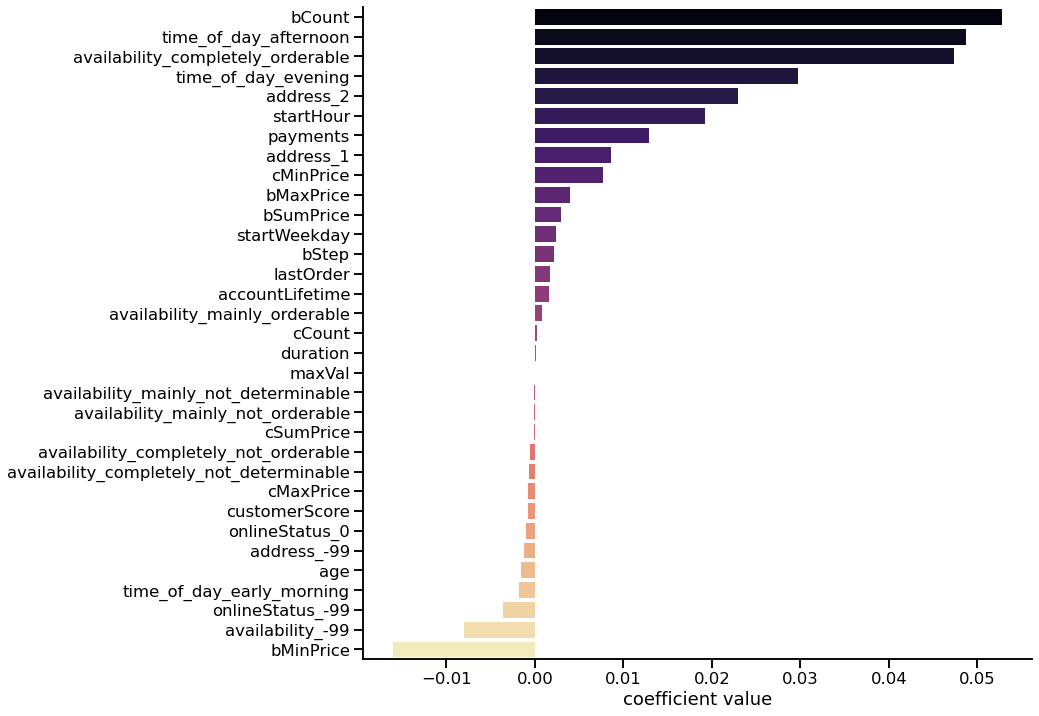

In [13]:
logres_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_logres.coef_[0]
    }
).sort_values(by='coef', ascending=False)
logres_coef['coef_abs'] = np.abs(logres_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=logres_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=RND)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_rf, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_rf.fit(X_train, y_train)

Iteration 1: Accuracy=92.155% | F1-score=92.265% | AUC=0.922
Iteration 2: Accuracy=92.003% | F1-score=92.073% | AUC=0.920
Iteration 3: Accuracy=92.255% | F1-score=92.390% | AUC=0.922
Iteration 4: Accuracy=92.159% | F1-score=92.288% | AUC=0.922
Iteration 5: Accuracy=92.322% | F1-score=92.374% | AUC=0.923
Cross-validation results
Accuracy: 92.179% +- 0.108%
F1-score: 92.278% +- 0.113%
AUC: 0.922 +- 0.001


RandomForestClassifier(random_state=121)

In [15]:
y_pred = model_rf.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 89.412%
F1-score : 92.423%
AUC: 0.869
              precision    recall  f1-score   support

           0       0.85      0.80      0.82     22992
           1       0.91      0.94      0.92     51159

    accuracy                           0.89     74151
   macro avg       0.88      0.87      0.87     74151
weighted avg       0.89      0.89      0.89     74151



In [16]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 121,
 'verbose': 0,
 'warm_start': False}

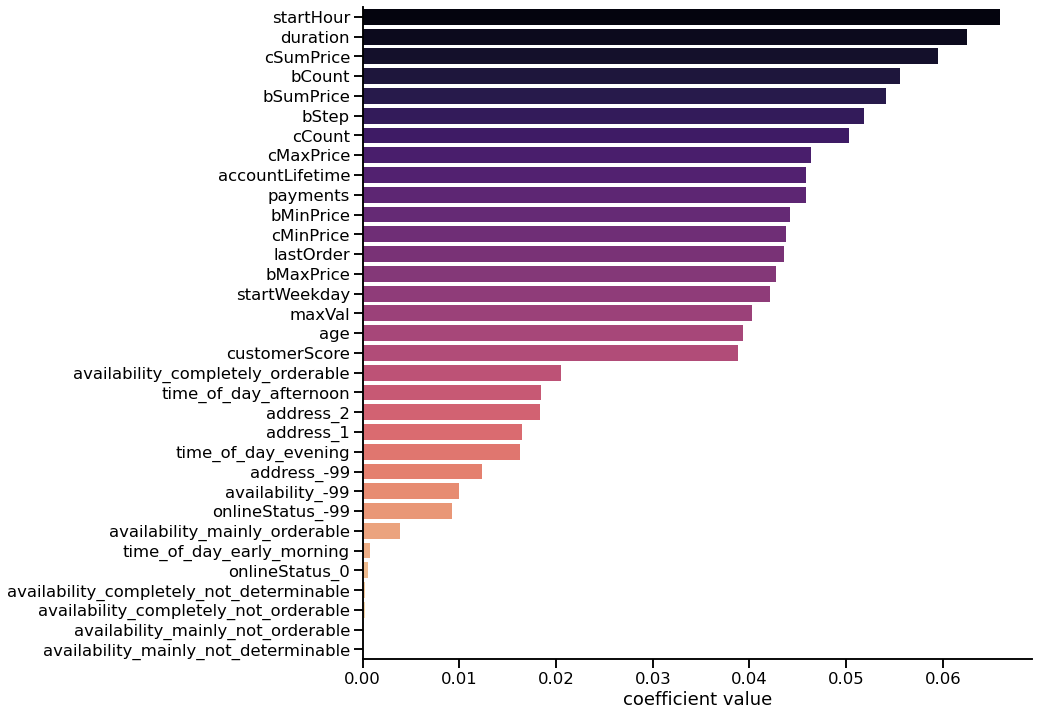

In [17]:
rf_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_rf.feature_importances_
    }
).sort_values(by='coef', ascending=False)
rf_coef['coef_abs'] = np.abs(rf_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=rf_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# LightGBM

In [18]:
import lightgbm as lgbm

model_lgbm = lgbm.LGBMClassifier(
    random_state=RND,
    objective='binary',
    learning_rate=0.2,
    subsample=0.7,
    subsample_freq=3,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_lgbm, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_lgbm.fit(X_train, y_train, categorical_feature=categorical_feature_list)

Iteration 1: Accuracy=84.406% | F1-score=85.148% | AUC=0.844
Iteration 2: Accuracy=84.300% | F1-score=85.044% | AUC=0.843
Iteration 3: Accuracy=84.336% | F1-score=85.116% | AUC=0.843
Iteration 4: Accuracy=84.777% | F1-score=85.460% | AUC=0.848
Iteration 5: Accuracy=84.514% | F1-score=85.160% | AUC=0.845
Cross-validation results
Accuracy: 84.467% +- 0.171%
F1-score: 85.186% +- 0.143%
AUC: 0.845 +- 0.002


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, objective='binary',
               random_state=121, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7,
               subsample_freq=3)

In [19]:
model_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 121,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 200000,
 'subsample_freq': 3}

In [20]:
y_pred = model_lgbm.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 79.072%
F1-score : 85.435%
AUC: 0.730
              precision    recall  f1-score   support

           0       0.70      0.57      0.63     22992
           1       0.82      0.89      0.85     51159

    accuracy                           0.79     74151
   macro avg       0.76      0.73      0.74     74151
weighted avg       0.78      0.79      0.78     74151



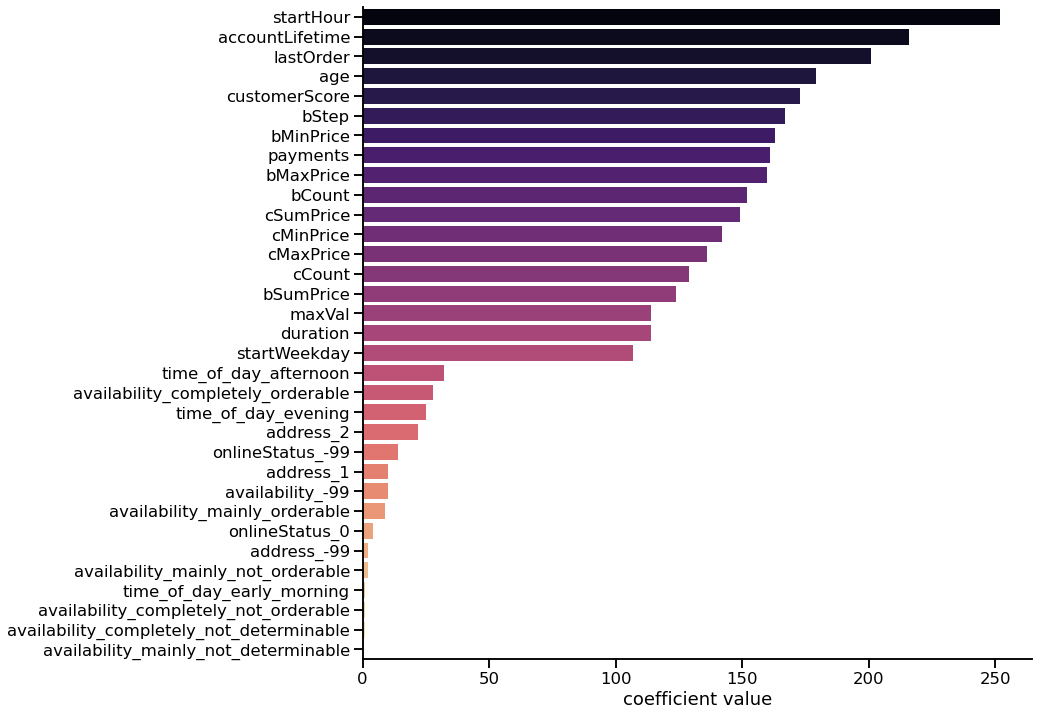

In [21]:
lgbm_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_lgbm.feature_importances_
    }
).sort_values(by='coef', ascending=False)
lgbm_coef['coef_abs'] = np.abs(lgbm_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=lgbm_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# Catboost

In [22]:
from catboost import CatBoostClassifier

## https://catboost.ai/en/docs/concepts/parameter-tuning
model_catboost = CatBoostClassifier(
    iterations=100,
    learning_rate=0.2,
    max_depth=10,
    l2_leaf_reg=0.1,
    random_state=RND
)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_catboost, X_train, y_train, k=KFOLD_ITER)

## Fit model
model_catboost.fit(X_train, y_train, cat_features=categorical_feature_list)
# # Get predicted classes
# preds_class = model_catboost.predict(eval_data)
# # Get predicted probabilities for each class
# preds_proba = model_catboost.predict_proba(eval_data)
# # Get predicted RawFormulaVal
# preds_raw = model_catboost.predict(eval_data, prediction_type='RawFormulaVal')

0:	learn: 0.6074809	total: 348ms	remaining: 34.5s
1:	learn: 0.5188089	total: 446ms	remaining: 21.9s
2:	learn: 0.4858722	total: 536ms	remaining: 17.3s
3:	learn: 0.4652947	total: 635ms	remaining: 15.2s
4:	learn: 0.4439955	total: 726ms	remaining: 13.8s
5:	learn: 0.4328762	total: 820ms	remaining: 12.9s
6:	learn: 0.4260266	total: 924ms	remaining: 12.3s
7:	learn: 0.4118167	total: 1.01s	remaining: 11.7s
8:	learn: 0.4071142	total: 1.11s	remaining: 11.2s
9:	learn: 0.4036016	total: 1.22s	remaining: 11s
10:	learn: 0.3997917	total: 1.31s	remaining: 10.6s
11:	learn: 0.3957800	total: 1.41s	remaining: 10.3s
12:	learn: 0.3902354	total: 1.51s	remaining: 10.1s
13:	learn: 0.3872783	total: 1.6s	remaining: 9.81s
14:	learn: 0.3835612	total: 1.69s	remaining: 9.59s
15:	learn: 0.3808825	total: 1.79s	remaining: 9.43s
16:	learn: 0.3780251	total: 1.89s	remaining: 9.21s
17:	learn: 0.3758054	total: 1.98s	remaining: 9.02s
18:	learn: 0.3734732	total: 2.08s	remaining: 8.86s
19:	learn: 0.3705106	total: 2.18s	remaining:

In [23]:
model_catboost.get_params()

{'iterations': 100,
 'learning_rate': 0.2,
 'l2_leaf_reg': 0.1,
 'max_depth': 10,
 'random_state': 121}

In [24]:
y_pred = model_catboost.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 83.976%
F1-score : 88.641%
AUC: 0.799
              precision    recall  f1-score   support

           0       0.77      0.69      0.73     22992
           1       0.87      0.91      0.89     51159

    accuracy                           0.84     74151
   macro avg       0.82      0.80      0.81     74151
weighted avg       0.84      0.84      0.84     74151



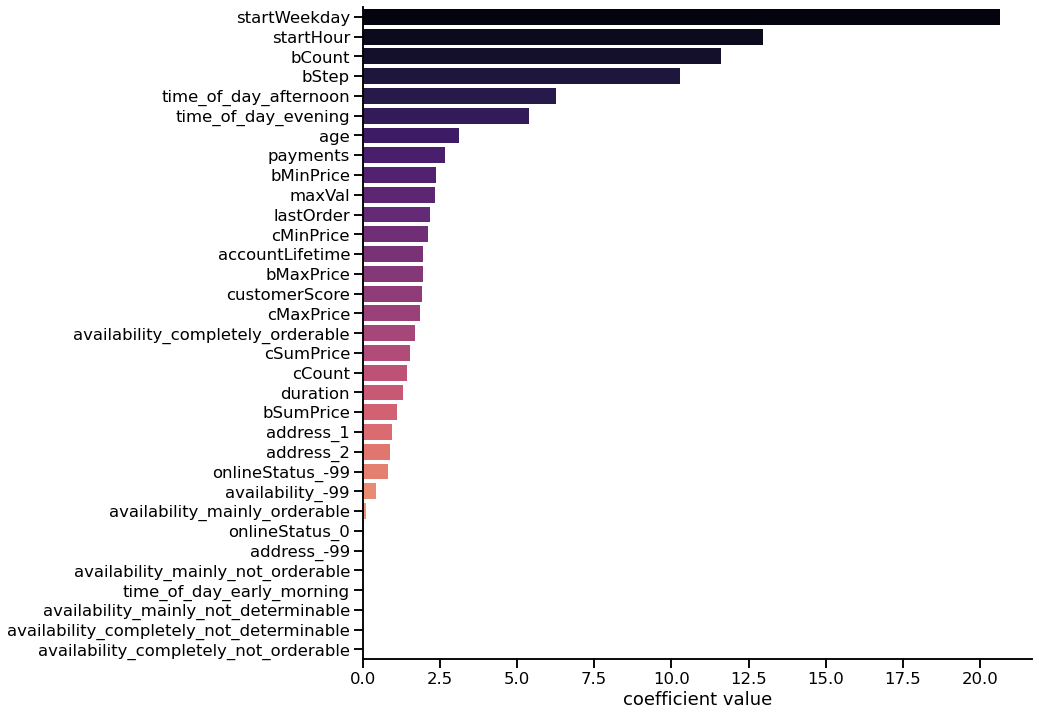

In [25]:
catboost_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_catboost.feature_importances_
    }
).sort_values(by='coef', ascending=False)
catboost_coef['coef_abs'] = np.abs(catboost_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=catboost_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();